<h1 style="font-size:3em; text-align: center">Using Uncertainty and Gaussian Distributions to Replace Custom Loss</h1>

Instead of using a custom loss function that penalizes over-estimates of the true value, we will use a very accurate neural network and a Gaussian distribution to choose the lower percentiles of the predictions rather than the average prediction (which will try to get as close to the true value as possible). This way, we can select what number in the uncertainty will be used in the real world application.

In [12]:
# imports
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import math
import keras
from scipy.stats  import norm
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras        import backend as K
from datetime     import datetime
from keras.optimizers      import RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics       import mean_squared_error
from matplotlib.pylab      import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 15, 6

# number of inputs to be fed
look_back = 288
# number of outputs to be generated
look_forward = 24

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_forward=2):
    dataX, dataY = [], []
    np.array(dataY)
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),0]
        if len(dataset[i + look_back:i+look_back+look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(dataset[i + look_back:i+look_back+look_forward, 0])
    return np.array(dataX), np.array(dataY)

def predict_with_uncertainty(model, dataset, n_iter=100):
    # This function activates drop-out when doing predictions
    f = K.function([model.layers[0].input, K.learning_phase()],
                      [model.layers[-1].output])
    all_pred = np.zeros((n_iter,) + (1,look_forward,))
    for iter in range(n_iter):
        all_pred[iter] = f([dataset, 1])
    avg_pred = all_pred.mean(axis=0)
    std = np.std(all_pred, axis=0)
    return all_pred, avg_pred, std

# given a model and data from the original dataset, it uses predict_with_uncertainty to 
def run_predictions (model, dataset):
    # normalizes the dataset and prepares it to be fed to the model
    dataset = np.array(dataset).transpose().reshape(-1, 1)
    dataset = scaler.fit_transform(dataset).transpose()
    data = (dataset.T)
    data = data.reshape(1, 1, data.shape[0])
    # feeds the model and data into a function that will activate the dro-out
    all_pred, avg_pred, std = predict_with_uncertainty(model, data)
    
    # All the predictions
    all_pred = scaler.inverse_transform(all_pred.reshape(all_pred.shape[0], all_pred.shape[-1]))
    # The Average Prediction
    avg_pred = scaler.inverse_transform(avg_pred)
    # The Standard Deviation At Each T Of Prediction
    std = scaler.inverse_transform(std)
    
    return all_pred, avg_pred, std


In [13]:
def predict (model, day=11, total_days=1, delta=1, show_gradual_error=False, show_graph=True):
    # creates matrices to hold the 
    avg_preds = np.zeros((288*total_days/delta, look_forward))
    true_vals = np.zeros((288*total_days/delta, look_forward))
    cdf_vals  = np.zeros((288*total_days/delta, look_forward))
    
    percent_over = np.zeros(288*total_days/delta)
    # Runs all the predictions
    for i in range (288*total_days/delta):
        # the point where the model will predict
        point = 288*day + i * delta
        
        # Gets predictions
        all_pred, avg_pred, std = run_predictions (model, dataset_orig[point-look_back:point].reshape(look_back))
        
        # Reshapes all of the things
        true_val = dataset_orig[point:point+look_forward].reshape(look_forward)
        avg_pred = avg_pred.reshape(look_forward)
        std = std.reshape(look_forward)
        
        percent_over[i] = 100.0 * (np.ones((len(all_pred),1) )*true_val - all_pred < 0).sum() / all_pred.size
        
        # converts the original values to cdf values according to the cumullative distibution functions at t+1, t+2, ..., t+24 (0.0-1.0)
        # Adds the values to the overall matrix of cdf
        cdf_vals[i,:] = norm.cdf(true_val, loc=avg_pred, scale=std)
        
        avg_preds[i], true_vals[i] = avg_pred, true_val
        
        if(show_graph):
            # plots the uncertainty to the degree of half a standard deviation
            plt.fill_between(range(point, point+look_forward), 
                             avg_pred + std/2.0, 
                             avg_pred - std/2.0, 
                             facecolor='red', alpha=0.25)

            # plots the uncertainty to the degree of a full standard deviation
            plt.fill_between(range(point, point+look_forward), 
                             avg_pred + std, 
                             avg_pred - std, 
                             facecolor='red', alpha=0.25)
        
            # plots the average predictions
            plt.plot(range(point, point+look_forward), avg_pred, color='red', alpha=1)
    
    print "Percent Overestimating: {}".format(np.mean(percent_over))
    
    if show_graph:
        plt.plot( np.arange(288*total_days+look_forward) + 288 * day, dataset_orig[288*day:288*day+288*total_days + look_forward,0])
        plt.axhline(0)
        plt.show()
    
    if show_gradual_error:
        indiv_err = true_vals - avg_preds
        for i in range(look_forward):
            plt.scatter(np.ones(len(indiv_err[:,i]))*i,indiv_err[:,i], color='black',alpha=0.1)
        plt.axhline(0)
        plt.show()
    return cdf_vals

In [14]:
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=288*21)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)

# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()

dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)

# split into train and test sets
train_size = 288*10
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]

# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [15]:
# creates a model but does not compile the model
def create_model(rate = 0.2):
    model = Sequential()
    model.add(Dropout(rate, input_shape=(1, look_back)))
    lstm = LSTM(256, recurrent_dropout=0.3)
    model.add(lstm)
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dense(look_forward))
    return model

Epoch 1/5
2s - loss: 0.0229
Epoch 2/5
2s - loss: 0.0099
Epoch 3/5
2s - loss: 0.0079
Epoch 4/5
2s - loss: 0.0072
Epoch 5/5
2s - loss: 0.0064
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
2s - loss: 0.0047
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
2s - loss: 0.0043
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
2s - loss: 0.0040
Percent Overestimating: 52.3472222222


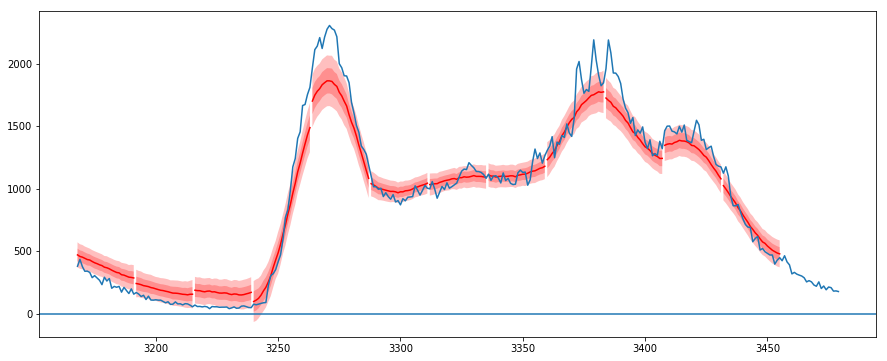

Epoch 1/5
2s - loss: 0.0288
Epoch 2/5
2s - loss: 0.0119
Epoch 3/5
2s - loss: 0.0095
Epoch 4/5
2s - loss: 0.0088
Epoch 5/5
2s - loss: 0.0078
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
2s - loss: 0.0053
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
2s - loss: 0.0047
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
2s - loss: 0.0045
Percent Overestimating: 50.8402777778


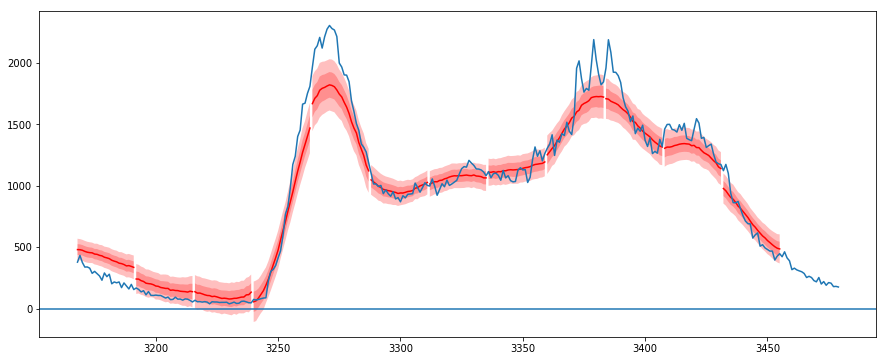

array([[ 0.1237492 ,  0.29716787,  0.1213521 ,  0.06883873,  0.07984281,
         0.06759676,  0.02209365,  0.0474204 ,  0.03523562,  0.02524573,
         0.0113413 ,  0.06956138,  0.04041098,  0.07774917,  0.0164494 ,
         0.0298344 ,  0.03068039,  0.04526592,  0.01801861,  0.05106013,
         0.04068826,  0.02306171,  0.06081448,  0.03051786],
       [ 0.27351579,  0.23595594,  0.21273671,  0.2547507 ,  0.19875527,
         0.28688944,  0.1941222 ,  0.20120591,  0.25100347,  0.24472691,
         0.26638626,  0.25340381,  0.24397016,  0.26026073,  0.24379613,
         0.24165282,  0.3097046 ,  0.25750788,  0.28377256,  0.27217191,
         0.30406126,  0.31856869,  0.27097021,  0.25559512],
       [ 0.30339168,  0.30467894,  0.29943634,  0.30172513,  0.33750446,
         0.34198716,  0.30148761,  0.37408011,  0.36003826,  0.37655052,
         0.38000158,  0.40277375,  0.39316992,  0.40531862,  0.37981044,
         0.39800197,  0.40379601,  0.37615453,  0.3614291 ,  0.39672617,
  

In [16]:
batch = 5
seed = 11
# create and fit the LSTM network
model = create_model(rate=0.2)
model2 = create_model(rate=0.2)

np.random.seed(seed)
model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=0.0002, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=5, batch_size=batch, verbose=2)
for i in range (30):
    if i % 10 == 9:
        model.fit(trainX, trainY, epochs=1, batch_size=batch, verbose=2)
    else:
        model.fit(trainX, trainY, epochs=1, batch_size=batch, verbose=3)
predict(model, total_days=1,day=11,delta=24)

np.random.seed(seed)
model2.compile(loss='mean_squared_error', optimizer=RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0002))
model2.fit(trainX, trainY, epochs=5, batch_size=batch, verbose=2)
for i in range (30):
    if i % 10 == 9:
        model2.fit(trainX, trainY, epochs=1, batch_size=batch, verbose=2)
    else:
        model2.fit(trainX, trainY, epochs=1, batch_size=batch, verbose=3)
predict(model2, total_days=1,day=11,delta=24)


Percent Overestimating: 49.4143518519


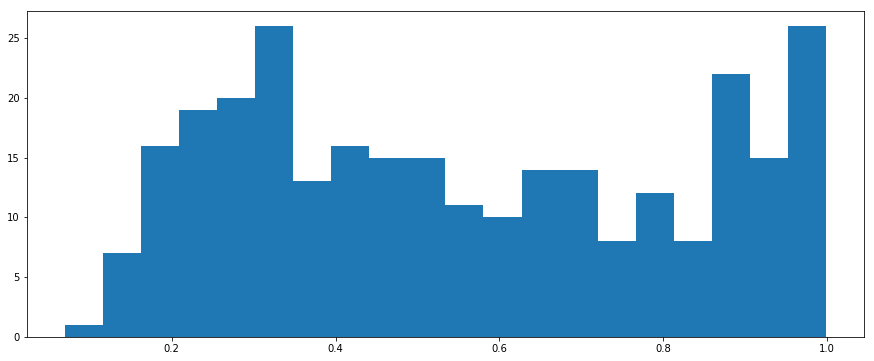

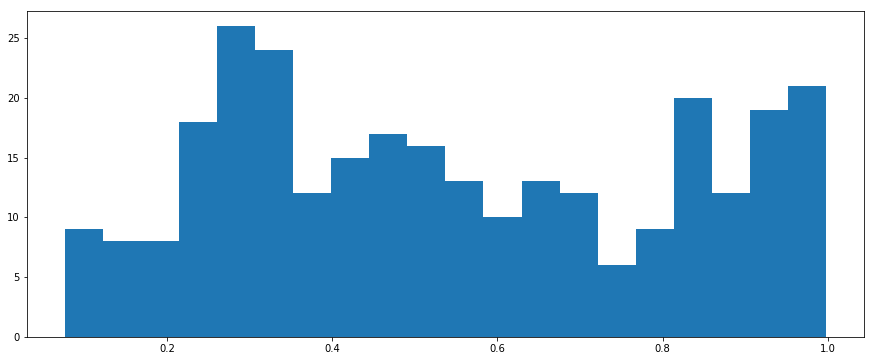

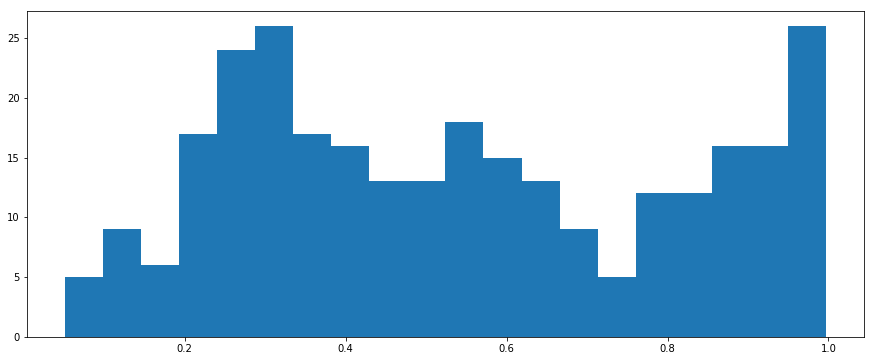

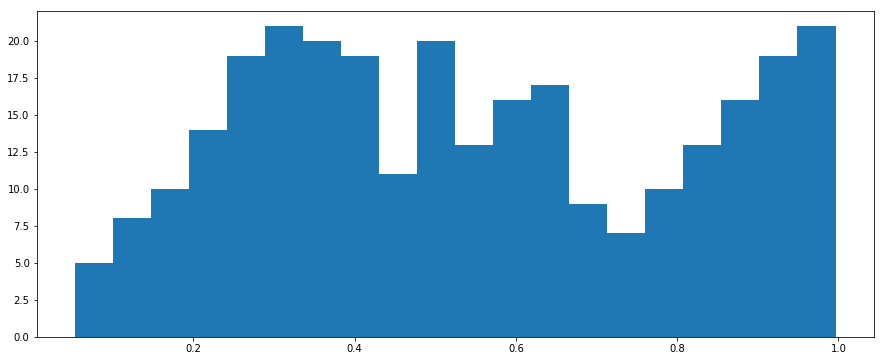

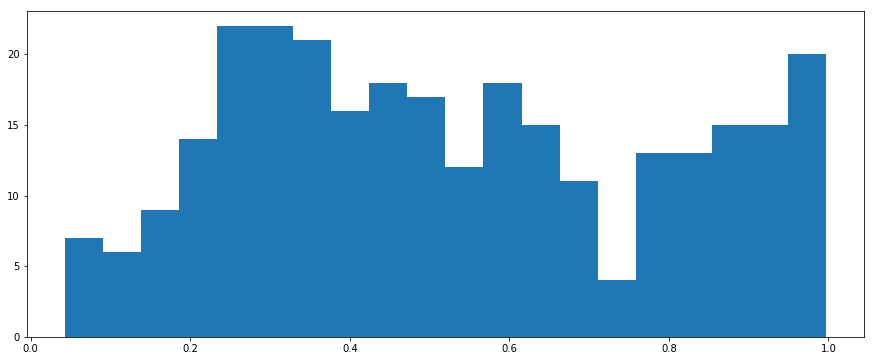

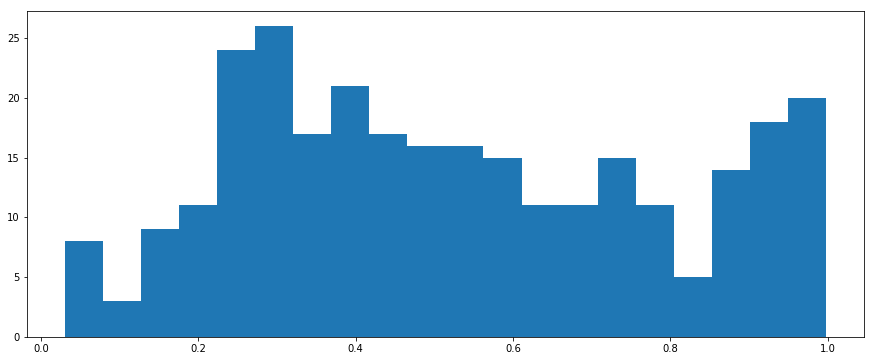

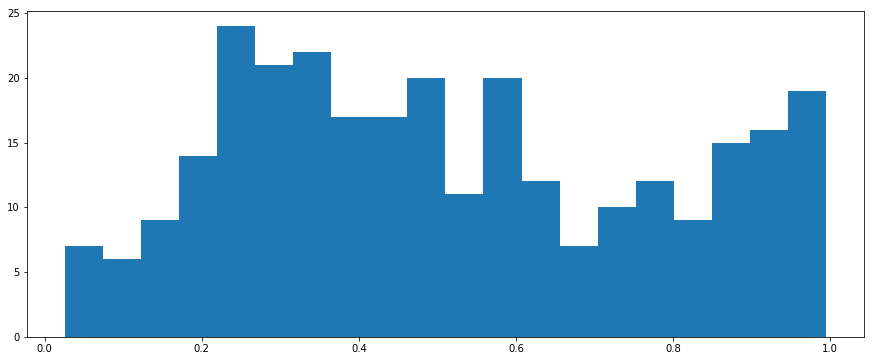

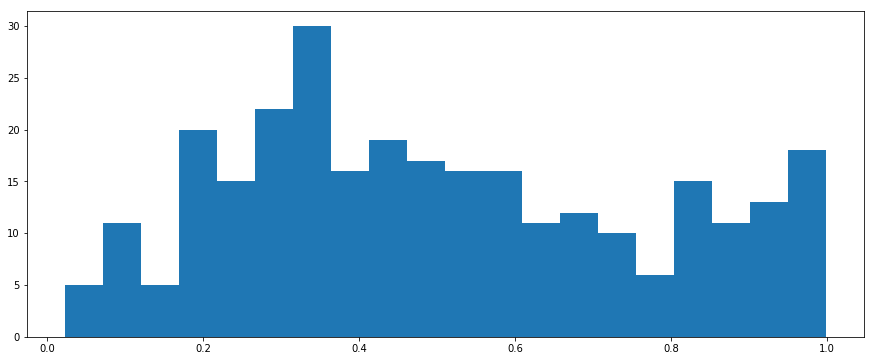

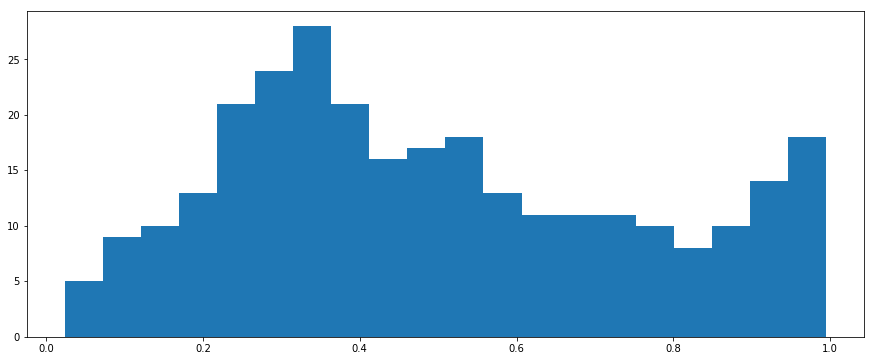

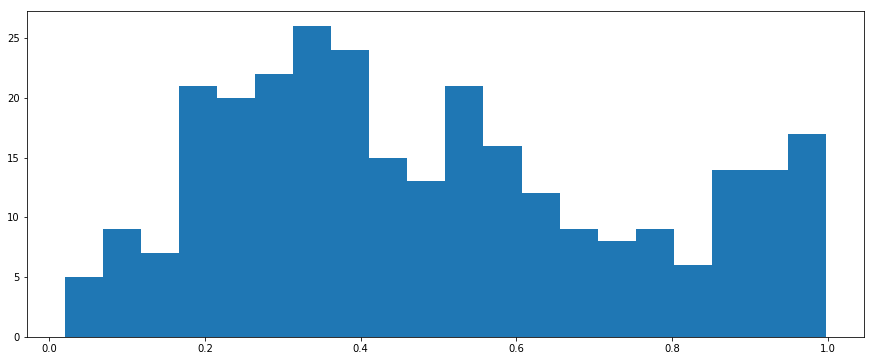

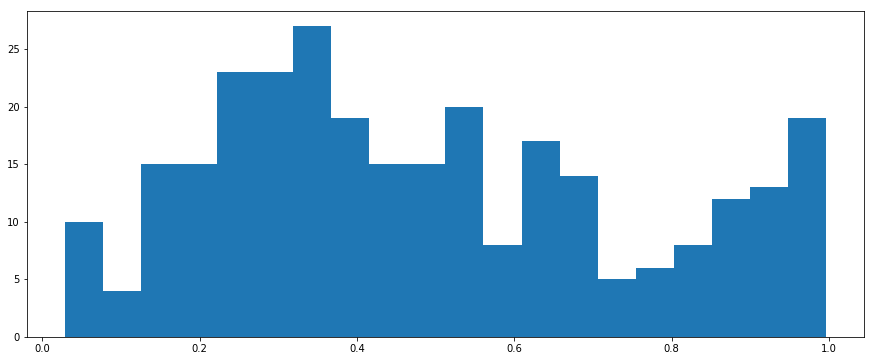

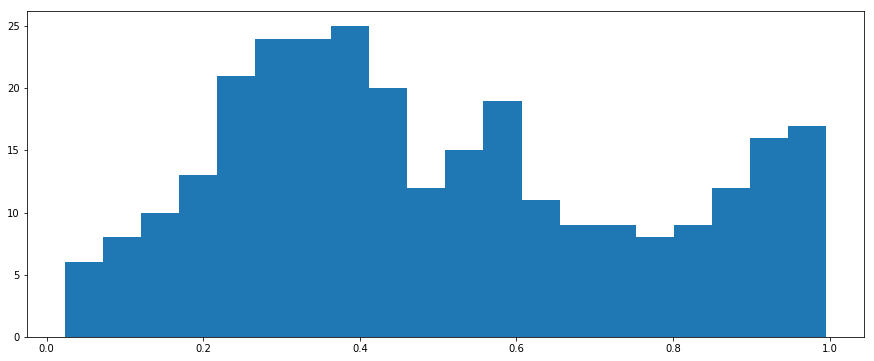

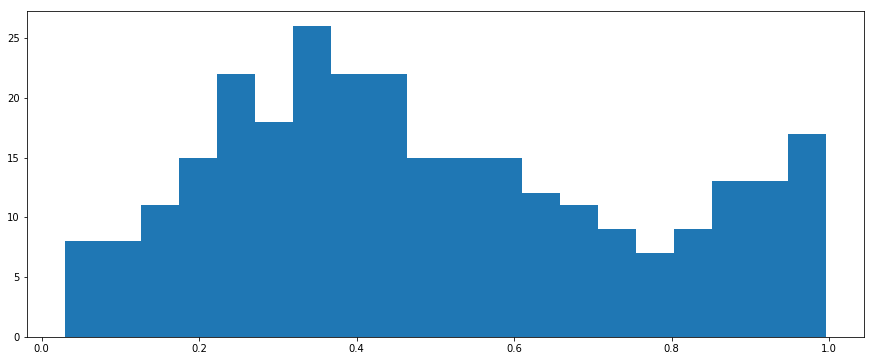

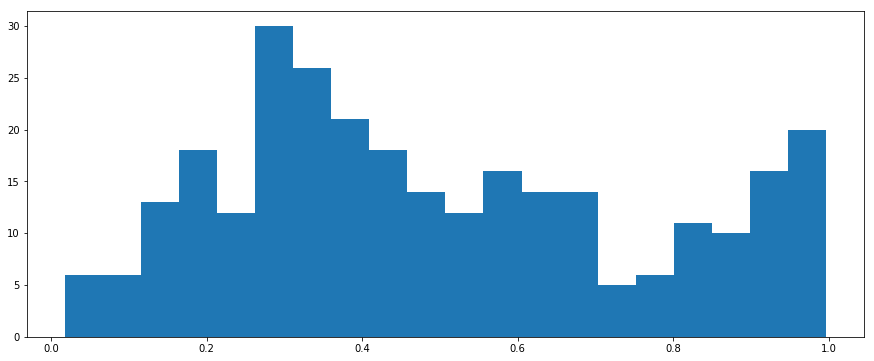

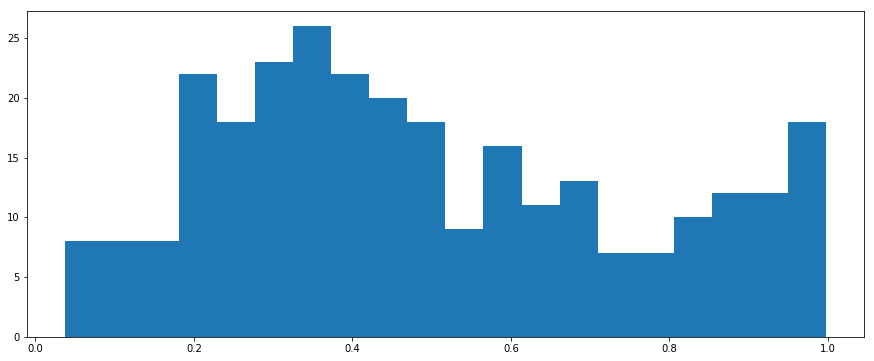

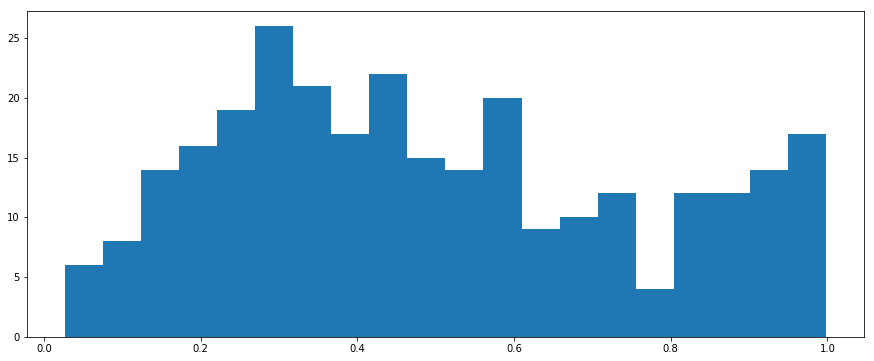

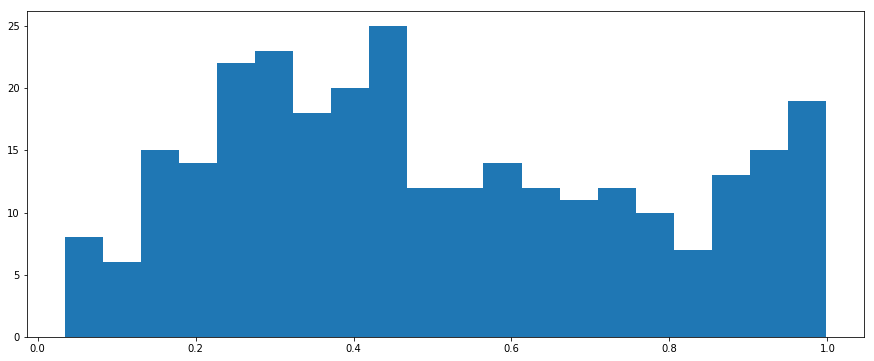

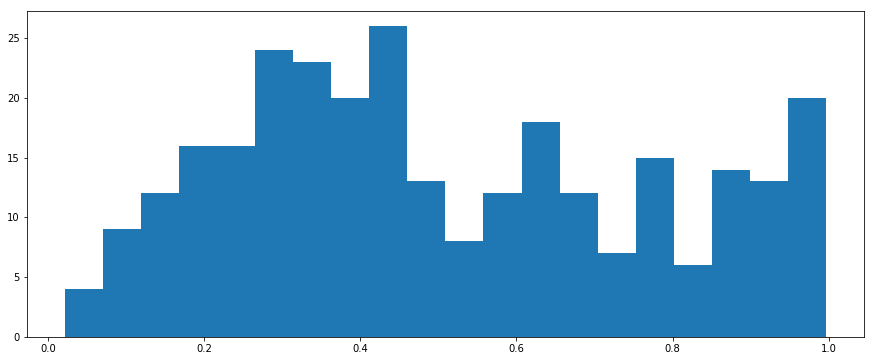

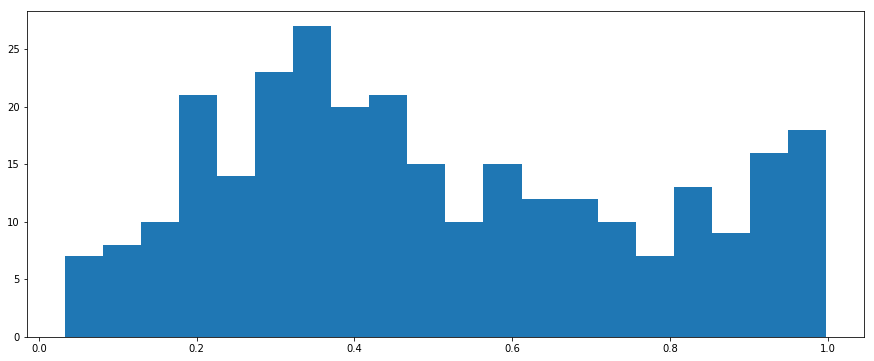

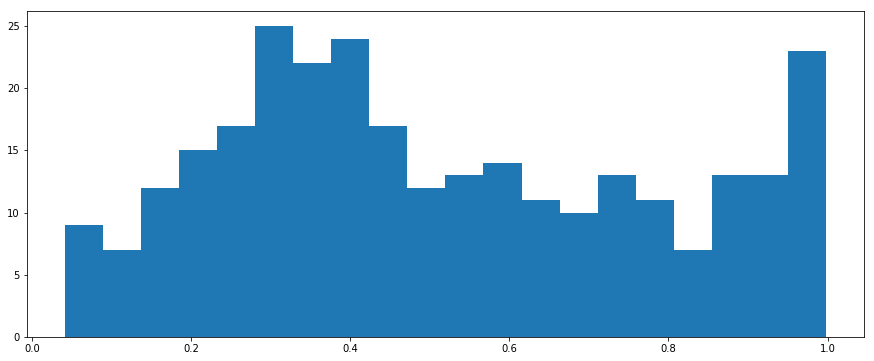

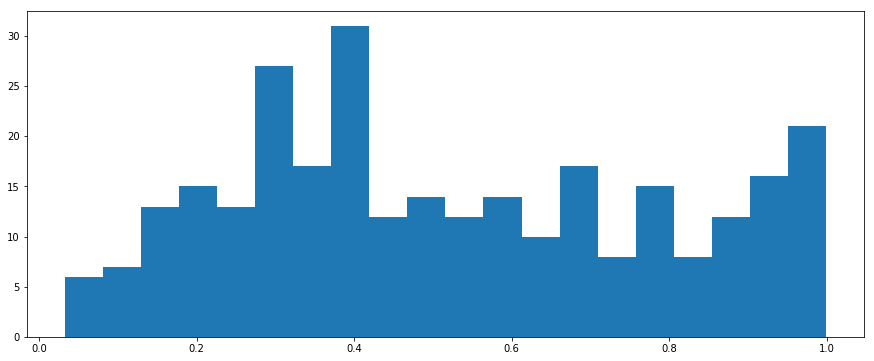

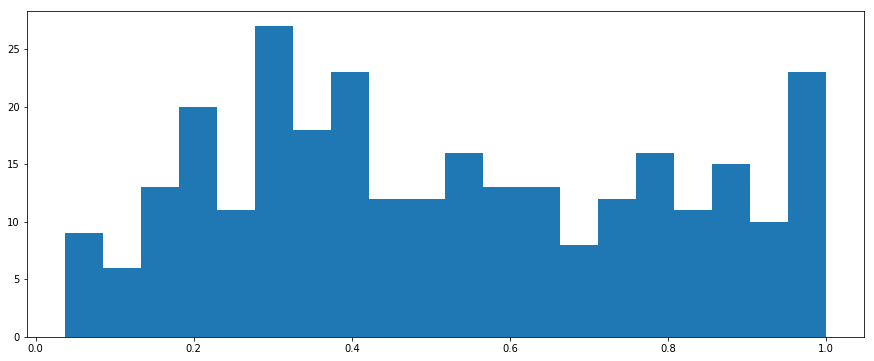

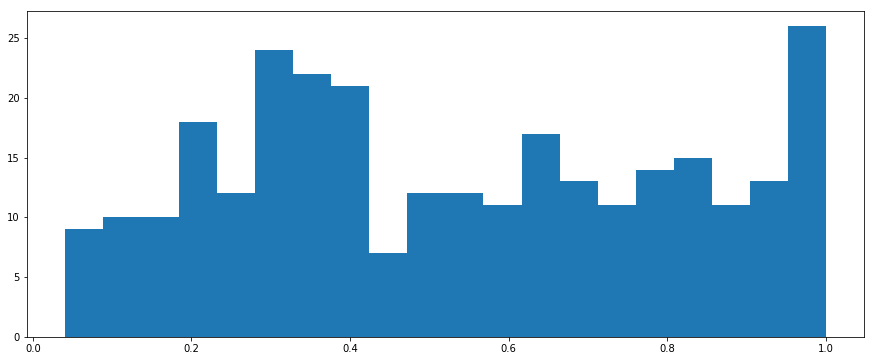

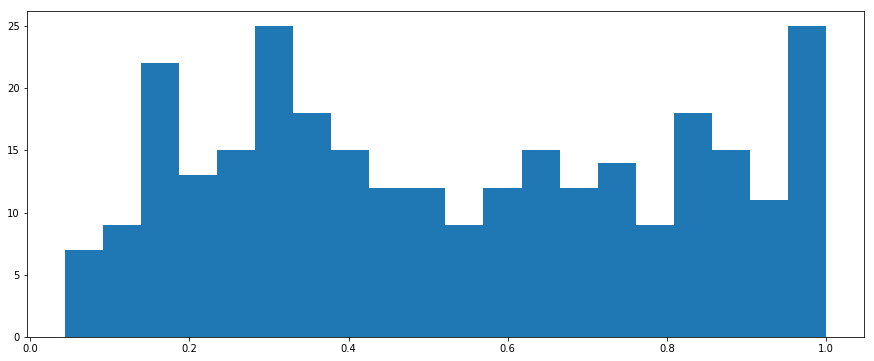

In [17]:
cdf_matrix = predict(model2, total_days=1,day=11,delta=1, show_graph=False)
for i in range (24):
    plt.hist(cdf_matrix[:,i],20)
    plt.show()

## We use Weights to Prioritize Accuracy in the Short Term

Hello
Epoch 1/5
11s - loss: 0.0161
Epoch 2/5
10s - loss: 0.0083
Epoch 3/5
10s - loss: 0.0070
Epoch 4/5
10s - loss: 0.0057
Epoch 5/5
10s - loss: 0.0057
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
10s - loss: 0.0043
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
10s - loss: 0.0041
Percent Overestimating: 58.6006944444


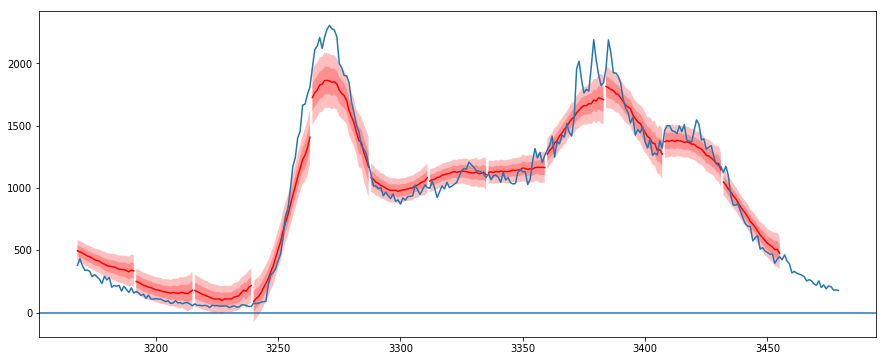

Percent Overestimating: 55.6361400463


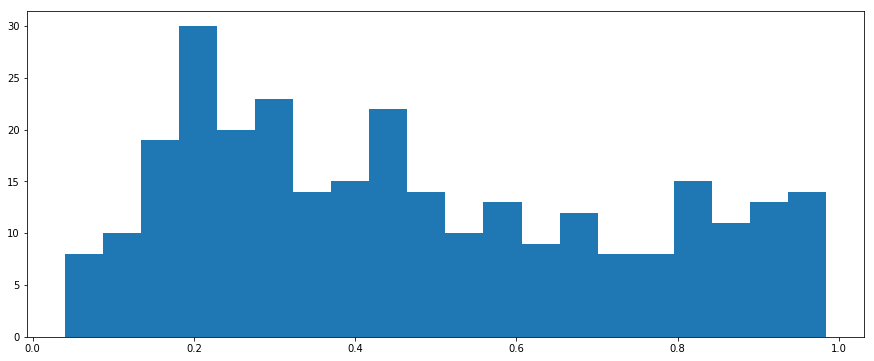

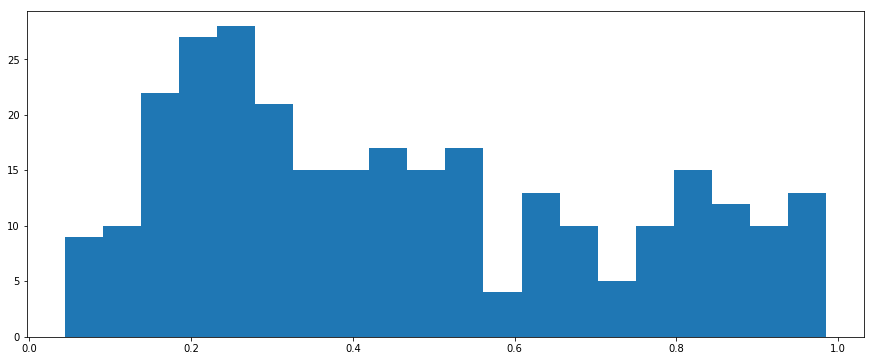

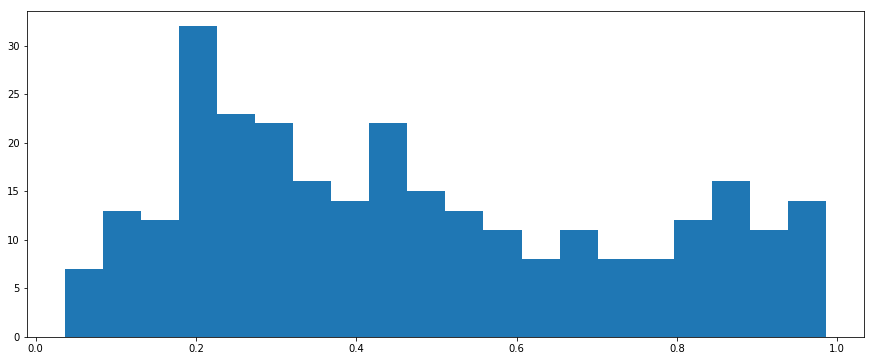

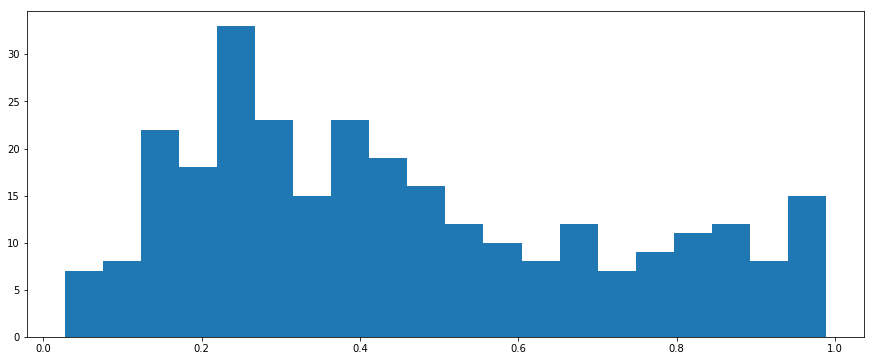

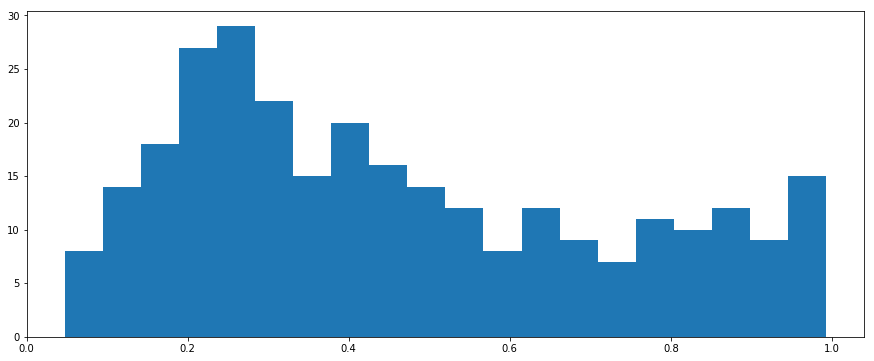

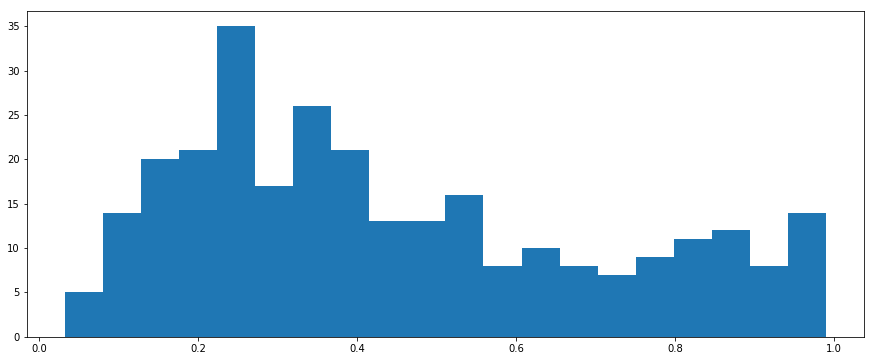

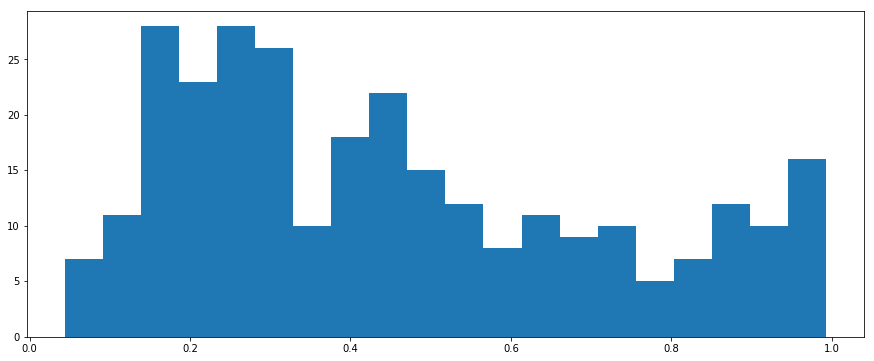

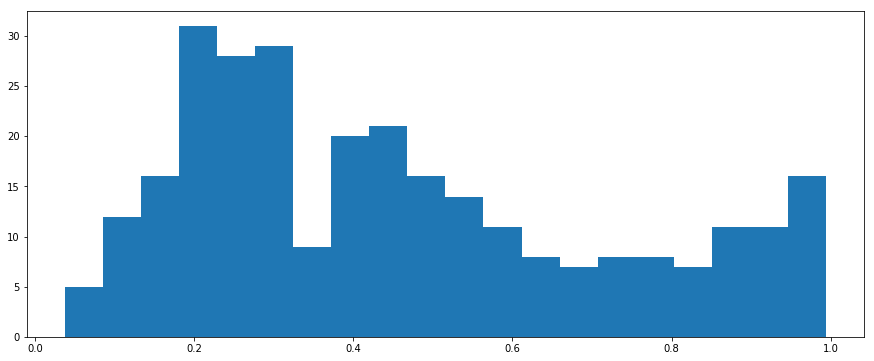

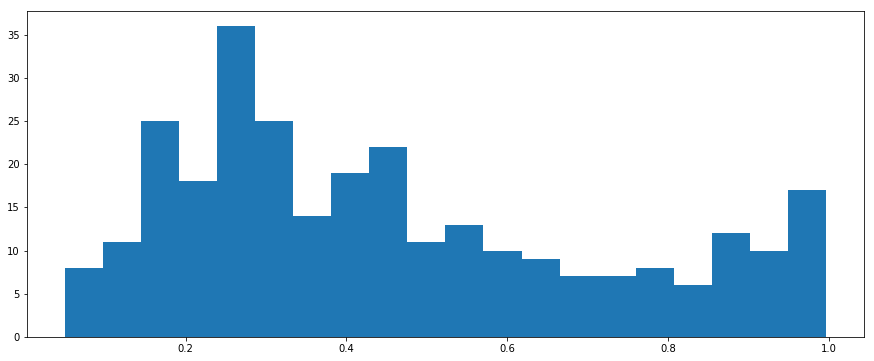

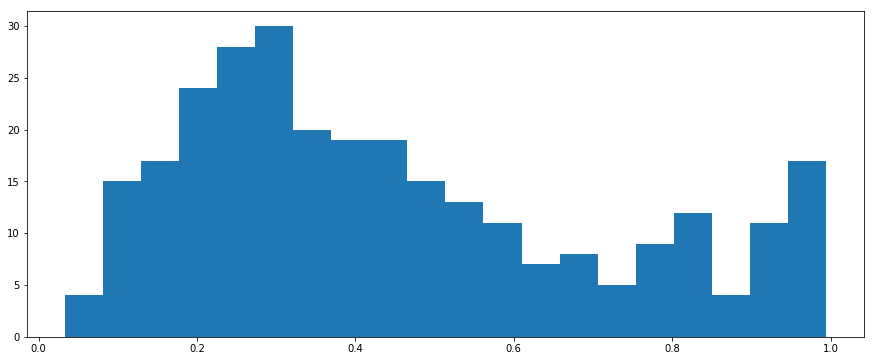

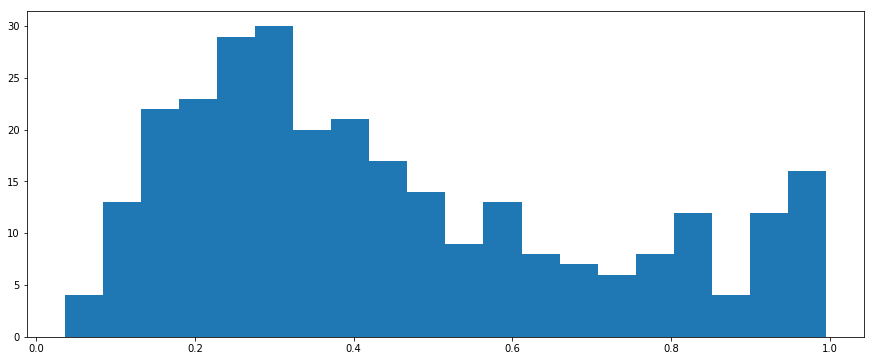

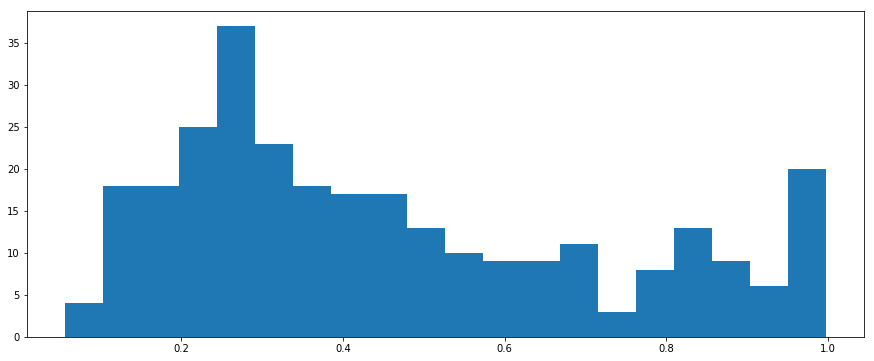

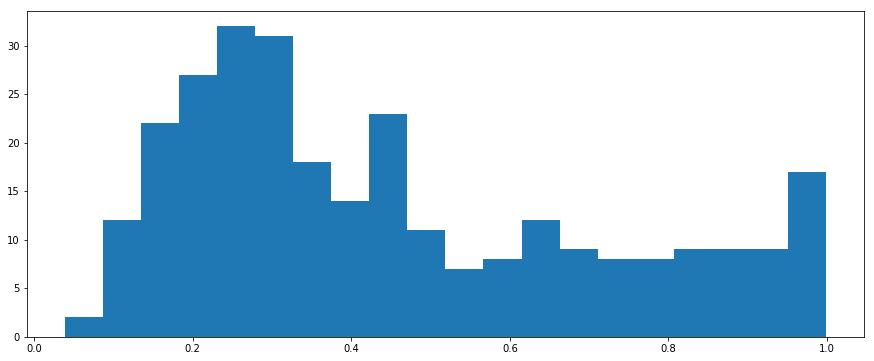

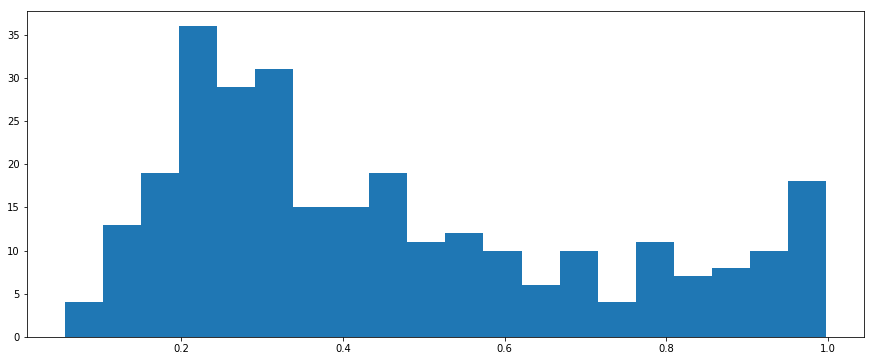

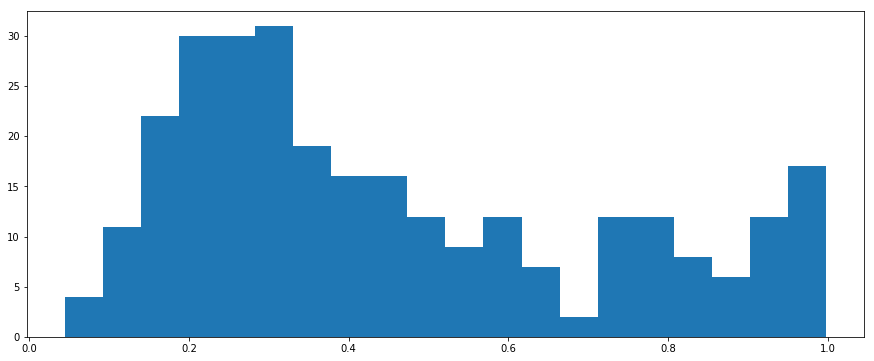

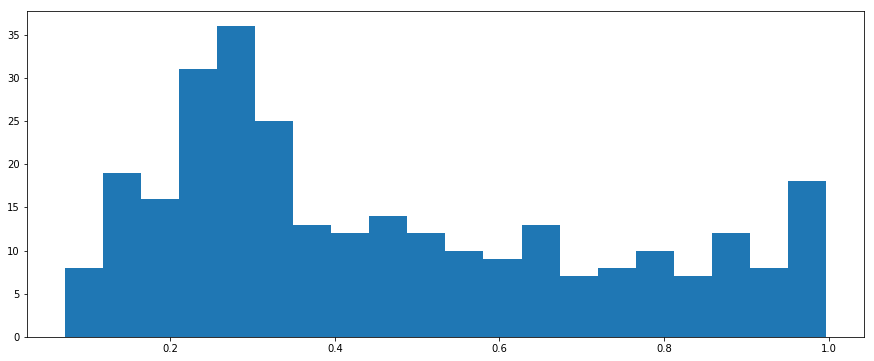

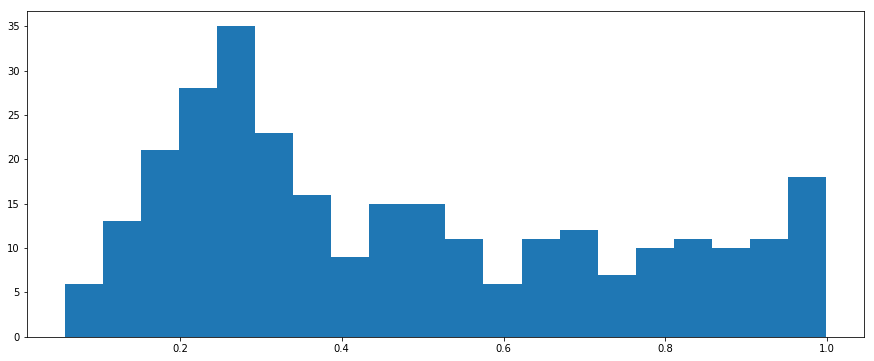

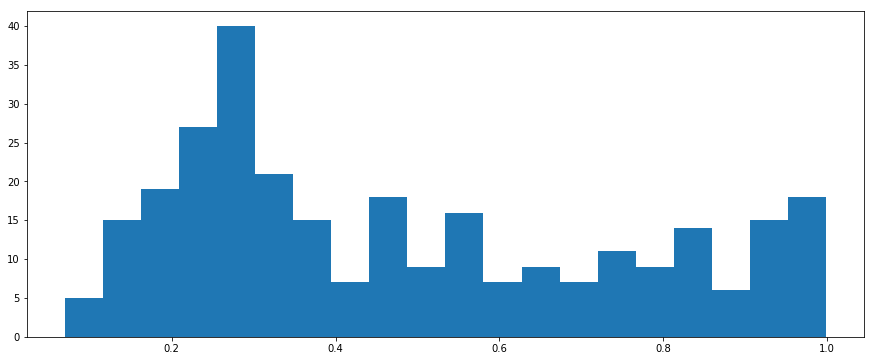

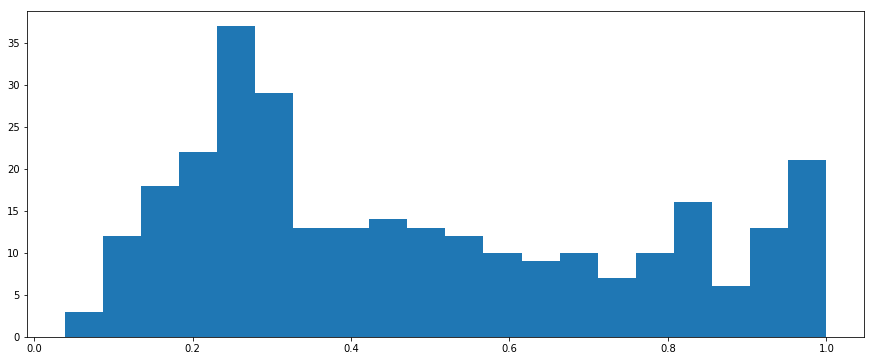

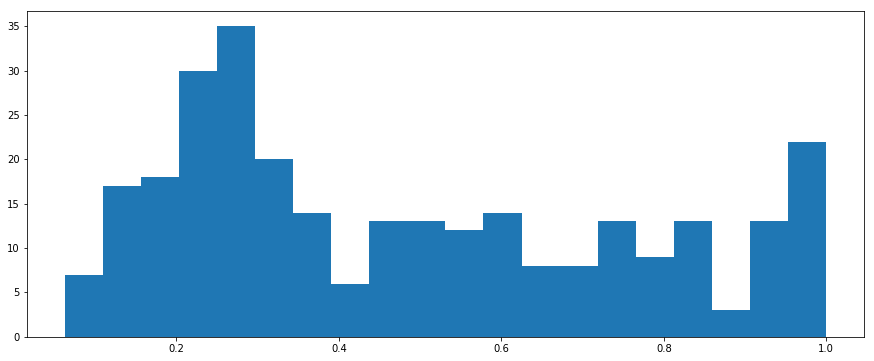

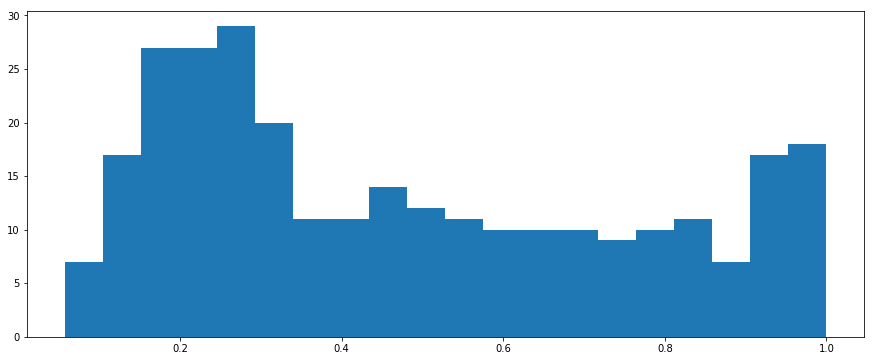

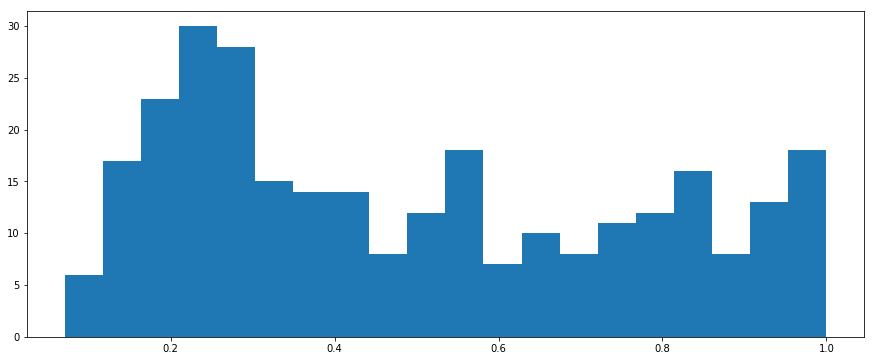

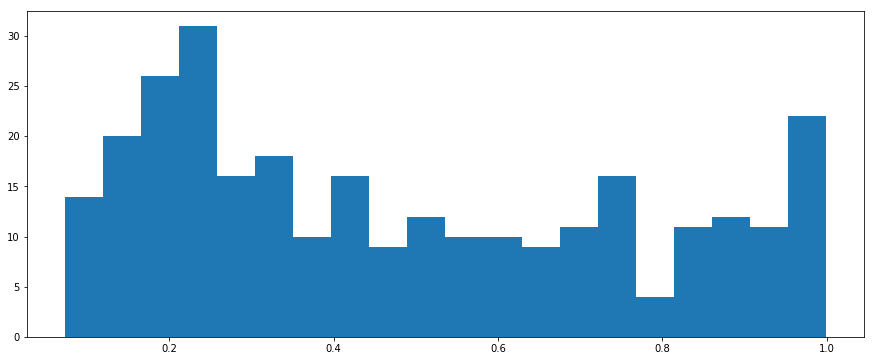

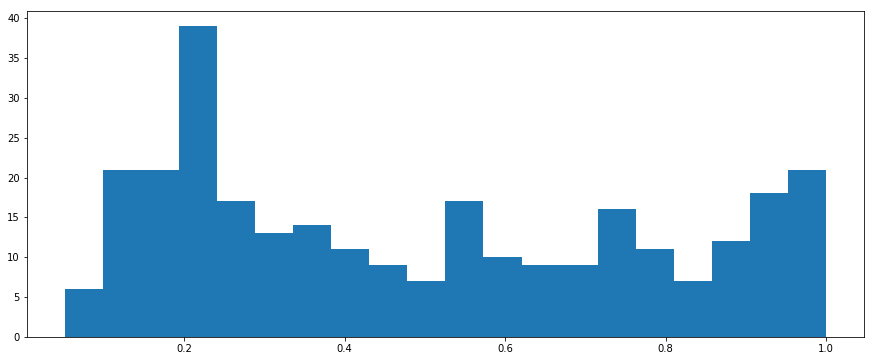

In [18]:

def priorities (y_true, y_pred):
    w = np.arange(1,0, -1./24)**1.3
    w = w / w.sum()
    w = w[:,None]
    
    W = K.variable(value = w)
    print "Hello"
    return K.dot( K.square(y_pred-y_true), W)

batch = 1
seed = 11
# create and fit the LSTM network
model = create_model(rate=0.2)

np.random.seed(seed)
model.compile(loss=priorities, optimizer=RMSprop(lr=0.0002, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=5, batch_size=batch, verbose=2)
for i in range (20):
    if i % 10 == 9:
        model.fit(trainX, trainY, epochs=1, batch_size=batch, verbose=2)
    else:
        model.fit(trainX, trainY, epochs=1, batch_size=batch, verbose=3)
predict(model, total_days=1,day=11,delta=24)

cdf_matrix = predict(model, total_days=1,day=11,delta=1, show_graph=False)
for i in range (24):
    plt.hist(cdf_matrix[:,i],20)
    plt.show()